### Movie Recommendation System using K-Means Clustering
Goal:

To group similar movies together based on user ratings and genres, allowing for recommendations to users with matching preferences. This task demonstrates how unsupervised learning can be applied in building movie recommendation systems.

### 1. Setup and Data Loading

In [3]:
import os
import urllib.request
import zipfile # Import the zipfile module

# Define the dataset URL and the directory to extract it to
dataset_url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
dataset_dir = "/root/.config/tensorflow/datasets/movielens/ml-100k/"
zip_path = "/tmp/ml-100k.zip"

# Check if the dataset directory already exists
if not os.path.exists(dataset_dir):
    print(f"Dataset directory not found. Downloading and extracting dataset to {dataset_dir}...")

    # Download the dataset
    urllib.request.urlretrieve(dataset_url, zip_path)

    # Extract the dataset
    with zipfile.ZipFile(zip_path, "r") as zip_ref: # Use zipfile.ZipFile
        zip_ref.extractall(path="/root/.config/tensorflow/datasets/movielens/")

    print("Dataset downloaded and extracted successfully.")
else:
    print(f"Dataset directory already exists at {dataset_dir}. Skipping download and extraction.")

# Verify that the required files exist after extraction
required_files = ['u.data', 'u.item']
for file_name in required_files:
    file_path = os.path.join(dataset_dir, file_name)
    if not os.path.exists(file_path):
        print(f"Error: Required file not found after extraction: {file_path}")
    else:
        print(f"Found required file: {file_path}")

Dataset directory not found. Downloading and extracting dataset to /root/.config/tensorflow/datasets/movielens/ml-100k/...
Dataset downloaded and extracted successfully.
Found required file: /root/.config/tensorflow/datasets/movielens/ml-100k/u.data
Found required file: /root/.config/tensorflow/datasets/movielens/ml-100k/u.item


### 2. Data Preprocessing and Feature Engineering

In [5]:
print("\n--- Data Preprocessing and Feature Engineering ---")

# Import necessary libraries for data manipulation, visualization, and machine learning

# For data manipulation and analysis
import pandas as pd  # Used for creating and manipulating DataFrames

# For numerical operations, especially for working with arrays
import numpy as np

# For creating static, interactive, and animated visualizations
import matplotlib.pyplot as plt
import seaborn as sns  # Built on Matplotlib, provides a high-level interface for drawing attractive statistical graphics

# For clustering algorithms
from sklearn.cluster import KMeans  # The K-Means clustering algorithm

# For dimensionality reduction (used for visualization)
from sklearn.decomposition import PCA  # Principal Component Analysis

# For preprocessing data, specifically scaling features
from sklearn.preprocessing import StandardScaler

# For evaluating clustering performance (optional, but good practice)
from sklearn.metrics import silhouette_score

# For setting a random seed to ensure reproducibility of results
np.random.seed(42)  # Ensures that random operations (like K-Means initialization) are consistent each run


# --- Load Datasets ---
print("Loading MovieLens 100k dataset...")

# Define the path to the dataset directory
dataset_dir = "/root/.config/tensorflow/datasets/movielens/ml-100k/"

# Define column names for the 'u.data' file (ratings)
# This file contains UserID, MovieID, Rating, and Timestamp
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
# Read the ratings data into a pandas DataFrame
ratings_df = pd.read_csv(f'{dataset_dir}u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Define column names for the 'u.item' file (movie information)
# This file contains MovieID, Title, ReleaseDate, VideoReleaseDate, IMDb_URL, and 19 genre flags
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
               'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# Read the movie information data into a pandas DataFrame
movies_df = pd.read_csv(f'{dataset_dir}u.item', sep='|', names=movies_cols, encoding='latin-1')

print("Datasets loaded successfully.")

# Display basic information and head of the loaded DataFrames
print("\n--- Ratings DataFrame Info ---")
print(ratings_df.info())  # Show concise summary of the ratings DataFrame
print("\nRatings DataFrame Head:")
print(ratings_df.head())  # Show the first 5 rows of the ratings DataFrame

print("\n--- Movies DataFrame Info ---")
print(movies_df.info())  # Show concise summary of the movies DataFrame
print("\nMovies DataFrame Head:")
print(movies_df.head())  # Show the first 5 rows of the movies DataFrame

# Step 1: Calculate Average Rating for each movie
# Group the ratings DataFrame by 'movie_id'
# Calculate the mean of 'rating' for each movie
avg_ratings = ratings_df.groupby('movie_id')['rating'].mean().reset_index()
avg_ratings.columns = ['movie_id', 'avg_rating']  # Rename the columns for clarity

# Step 2: Calculate Number of Ratings for each movie
# Group the ratings DataFrame by 'movie_id'
# Count the number of 'rating' entries for each movie
num_ratings = ratings_df.groupby('movie_id')['rating'].count().reset_index()
num_ratings.columns = ['movie_id', 'num_ratings']  # Rename the columns for clarity

# Step 3: Merge movie features
# Select relevant columns from movies_df: movie_id, title, and all genre columns
# The genre columns (from 'unknown' to 'Western') are already one-hot encoded (binary flags)
movie_features_df = movies_df[['movie_id', 'title'] + movies_cols[5:]] # movies_cols[5:] slices from 'unknown' onwards

# Merge average ratings and number of ratings with movie features
# Merge 'movie_features_df' with 'avg_ratings' on 'movie_id' (left join to keep all movies)
movie_features_df = pd.merge(movie_features_df, avg_ratings, on='movie_id', how='left')
# Merge the result with 'num_ratings' on 'movie_id'
movie_features_df = pd.merge(movie_features_df, num_ratings, on='movie_id', how='left')

# Step 4: Handle missing values (for movies that might not have ratings)
# If a movie has no ratings, its 'avg_rating' and 'num_ratings' will be NaN after merging.
# Fill 'avg_rating' with 0 if no ratings (or the overall average if preferred)
movie_features_df['avg_rating'].fillna(0, inplace=True)
# Fill 'num_ratings' with 0 if no ratings
movie_features_df['num_ratings'].fillna(0, inplace=True)

# Display the processed movie features DataFrame head
print("\nProcessed Movie Features DataFrame Head:")
print(movie_features_df.head())
print("\nProcessed Movie Features DataFrame Info (check for NaNs):")
print(movie_features_df.info())

# Step 5: Select features for clustering
# We will use 'avg_rating', 'num_ratings', and all genre columns for clustering
features_for_clustering = movie_features_df.columns.drop(['movie_id', 'title'])
X = movie_features_df[features_for_clustering]

# Display the features matrix head before scaling
print("\nFeatures for Clustering (before scaling) Head:")
print(X.head())

# Step 6: Feature Scaling
# Scaling is crucial for K-Means as it's a distance-based algorithm.
# Features with larger values (e.g., num_ratings) would dominate the distance calculation.
scaler = StandardScaler()  # Initialize StandardScaler
X_scaled = scaler.fit_transform(X)  # Fit the scaler to the data and transform it

# Convert scaled features back to a DataFrame for easier inspection (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)
print("\nScaled Features for Clustering Head:")
print(X_scaled_df.head())


--- Data Preprocessing and Feature Engineering ---
Loading MovieLens 100k dataset...
Datasets loaded successfully.

--- Ratings DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None

Ratings DataFrame Head:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

--- Movies DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------   

/tmp/ipython-input-5-325026316.py:90: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movie_features_df['avg_rating'].fillna(0, inplace=True)
/tmp/ipython-input-5-325026316.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

### 3. Exploratory Data Analysis (EDA) on Features


--- Exploratory Data Analysis (EDA) on Features ---


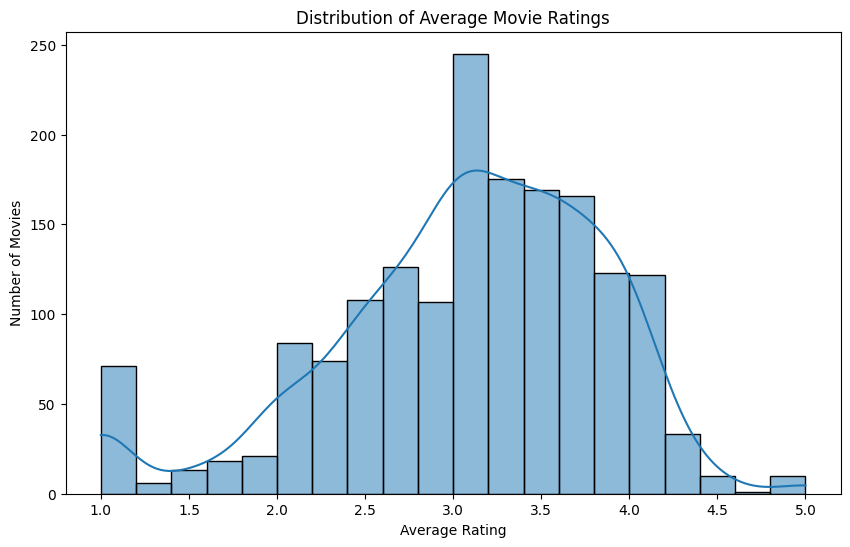

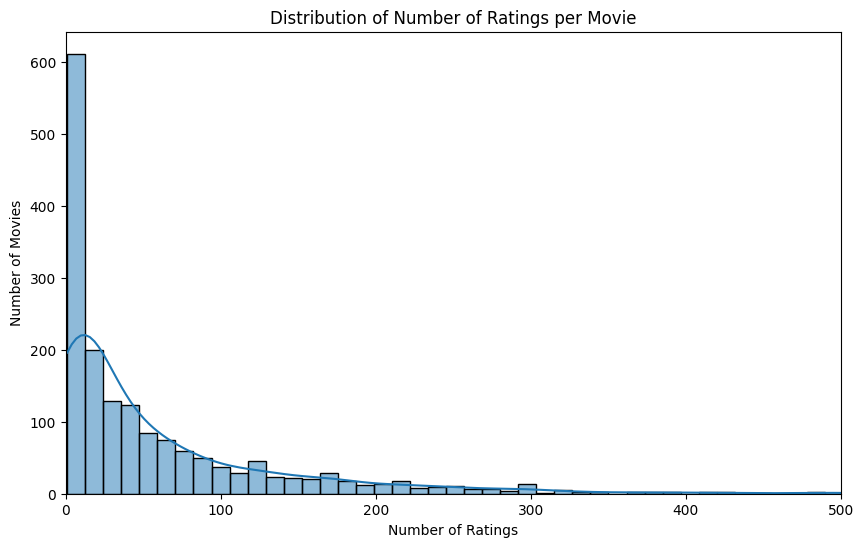

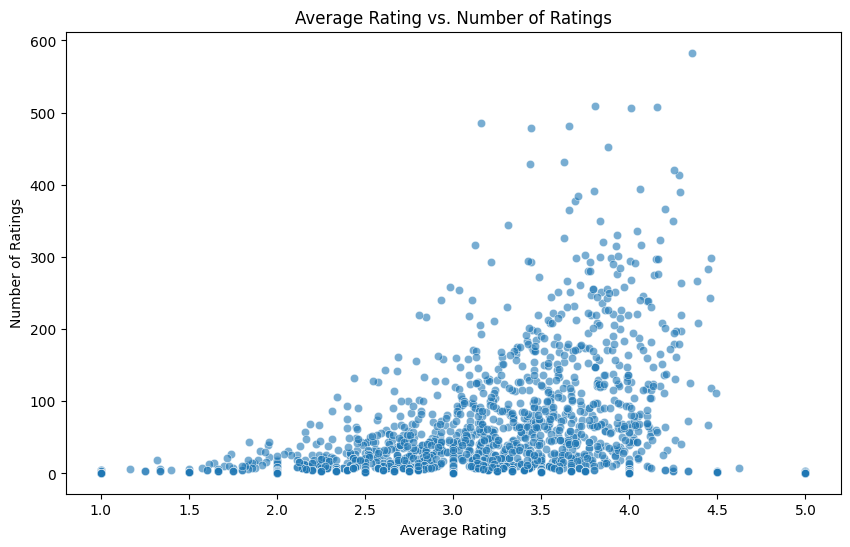

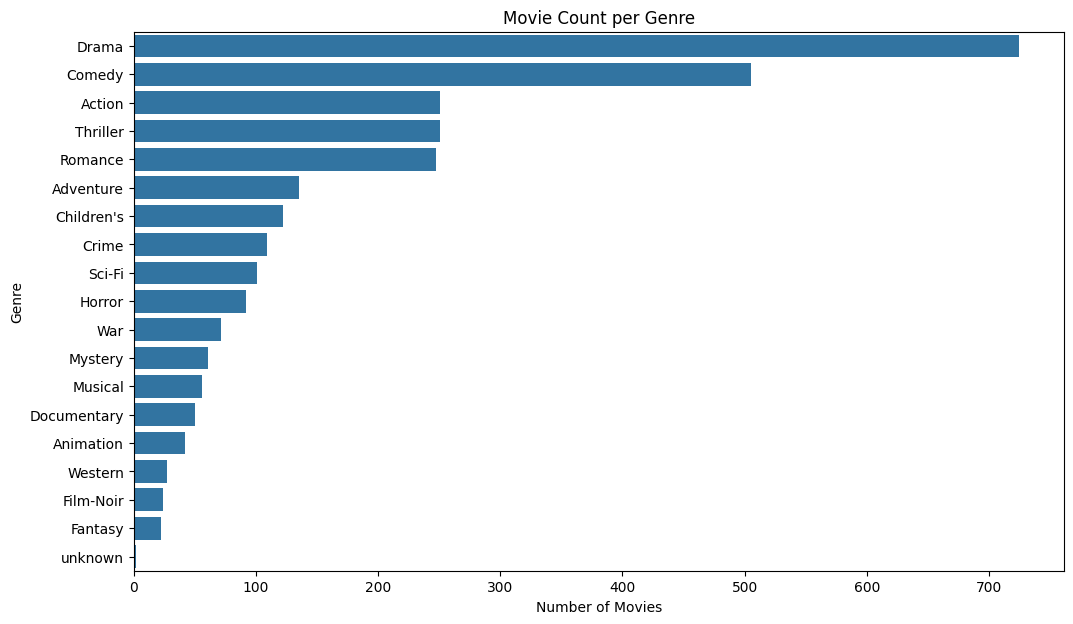

In [6]:
print("\n--- Exploratory Data Analysis (EDA) on Features ---")

# Visualize distributions of key features before clustering

# Distribution of Average Ratings
plt.figure(figsize=(10, 6))  # Create a new figure
sns.histplot(movie_features_df['avg_rating'], bins=20, kde=True)  # Plot histogram with KDE
plt.title('Distribution of Average Movie Ratings')  # Set title
plt.xlabel('Average Rating')  # Set x-label
plt.ylabel('Number of Movies')  # Set y-label
plt.show()  # Display plot

# Distribution of Number of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_features_df['num_ratings'], bins=50, kde=True)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.xlim(0, 500) # Limit x-axis for better visualization due to long tail
plt.show()

# Visualize relationships between key numerical features (pre-scaling values for interpretability)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_rating', y='num_ratings', data=movie_features_df, alpha=0.6)
plt.title('Average Rating vs. Number of Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')
plt.show()

# Visualize genre popularity (sum of 1s in genre columns)
genre_counts = movie_features_df[movies_cols[5:]].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Movie Count per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

### 4. K-Means Clustering


--- K-Means Clustering ---
Calculating inertia and silhouette scores for different k values...


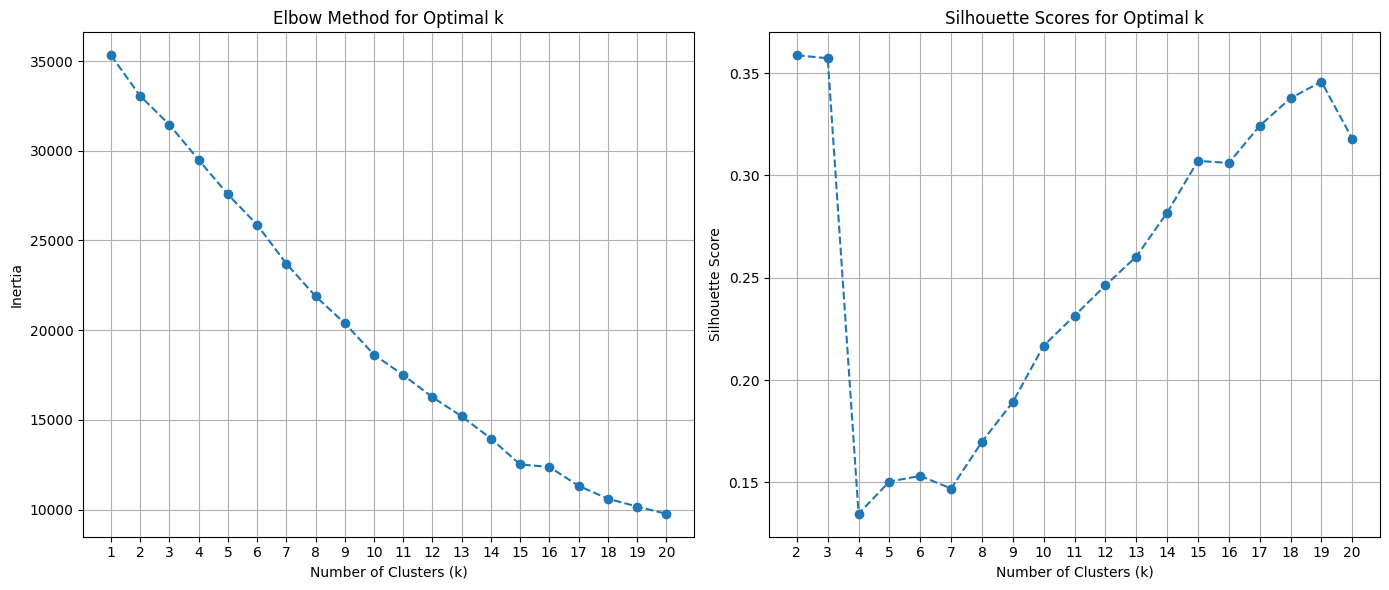


Chosen optimal number of clusters (k): 7 (based on Elbow method interpretation)
Clustering complete. 7 clusters identified.

Movie Features DataFrame with Cluster Labels Head:
   movie_id              title  unknown  Action  Adventure  Animation  \
0         1   Toy Story (1995)        0       0          0          1   
1         2   GoldenEye (1995)        0       1          1          0   
2         3  Four Rooms (1995)        0       0          0          0   
3         4  Get Shorty (1995)        0       1          0          0   
4         5     Copycat (1995)        0       0          0          0   

   Children's  Comedy  Crime  Documentary  ...  Musical  Mystery  Romance  \
0           1       1      0            0  ...        0        0        0   
1           0       0      0            0  ...        0        0        0   
2           0       0      0            0  ...        0        0        0   
3           0       1      0            0  ...        0        0        0   

In [7]:
print("\n--- K-Means Clustering ---")

# Step 1: Determine Optimal Number of Clusters (k) using Elbow Method

# List to store inertia values for different k
inertias = []
# List to store silhouette scores for different k (requires k > 1)
silhouette_scores = []

# Iterate through a range of k values (e.g., from 1 to 20)
print("Calculating inertia and silhouette scores for different k values...")
for k in range(1, 21):
    # Initialize KMeans model with 'k' clusters
    # n_init='auto' ensures multiple initializations to find the best centroids
    # random_state for reproducibility
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_scaled)  # Fit KMeans to the scaled data
    inertias.append(kmeans.inertia_)  # Append the inertia (sum of squared distances to closest centroid)

    # Calculate Silhouette Score for k > 1
    if k > 1:
        # silhouette_score measures how similar an object is to its own cluster (cohesion)
        # compared to other clusters (separation). Higher is better.
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotting the Elbow Curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # Create the first subplot
plt.plot(range(1, 21), inertias, marker='o', linestyle='--')  # Plot k vs inertia
plt.title('Elbow Method for Optimal k')  # Title
plt.xlabel('Number of Clusters (k)')  # X-axis label
plt.ylabel('Inertia')  # Y-axis label
plt.xticks(range(1, 21)) # Ensure integer ticks on x-axis
plt.grid(True) # Add grid for better readability

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)  # Create the second subplot
# Note: Silhouette score starts from k=2
plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 21))
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display plots

# Based on the Elbow plot, choose an optimal k (e.g., where the curve bends significantly)
# A common choice for this dataset is k=5 or k=7. Let's pick k=7 for demonstration.
optimal_k = 7
print(f"\nChosen optimal number of clusters (k): {optimal_k} (based on Elbow method interpretation)")

# Step 2: Apply K-Means Clustering with the chosen optimal k
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42) # Initialize KMeans
# Fit the model to the scaled data and predict cluster labels for each movie
movie_features_df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Clustering complete. {optimal_k} clusters identified.")
print("\nMovie Features DataFrame with Cluster Labels Head:")
print(movie_features_df.head())

### 5. Cluster Visualization


--- Cluster Visualization ---


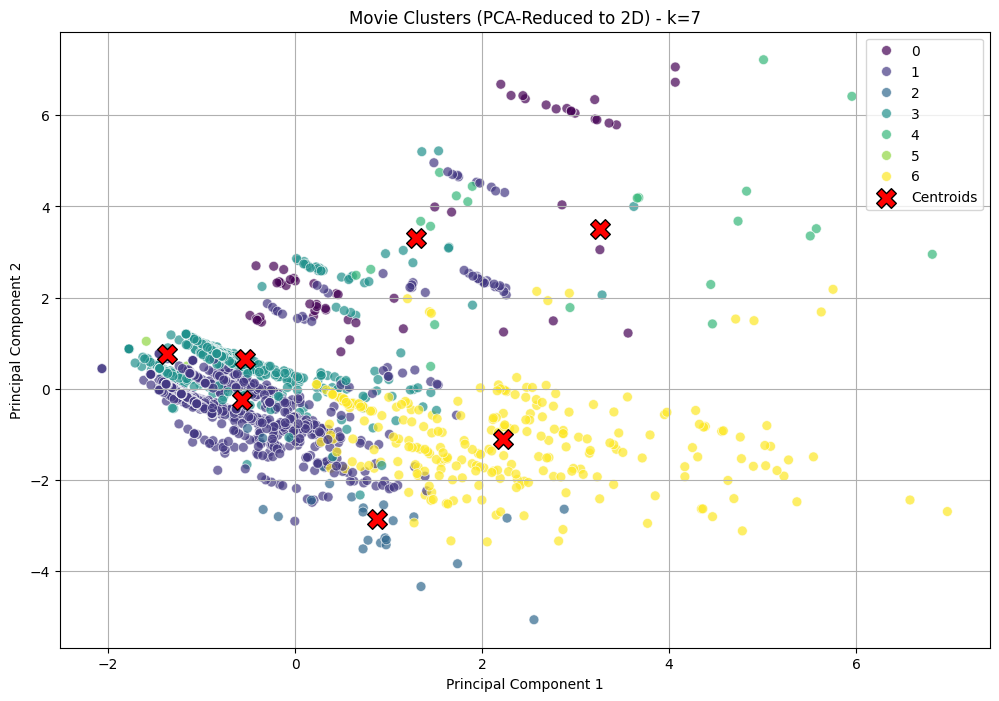

In [8]:
print("\n--- Cluster Visualization ---")

# To visualize clusters in 2D, we'll use PCA (Principal Component Analysis)
# PCA reduces the dimensionality of our feature space (avg_rating, num_ratings, 19 genres)
# down to 2 components, which we can plot.

pca = PCA(n_components=2)  # Initialize PCA to reduce to 2 dimensions
# Fit PCA to the scaled features and transform them
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to our movie features DataFrame for easy plotting
movie_features_df['pca_1'] = X_pca[:, 0]  # First principal component
movie_features_df['pca_2'] = X_pca[:, 1]  # Second principal component

# Plot the clusters using PCA components
plt.figure(figsize=(12, 8))  # Create a new figure
# Create a scatter plot with PCA components on axes and cluster as color
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=movie_features_df,
                palette='viridis', s=50, alpha=0.7)

# Plot cluster centroids (transformed by PCA)
# Get the cluster centroids from the KMeans model
centroids = kmeans.cluster_centers_
# Transform the centroids using the same PCA model
centroids_pca = pca.transform(centroids)
# Plot the centroids on top of the scatter plot as larger, distinct markers
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200,
            color='red', edgecolor='black', label='Centroids')

plt.title(f'Movie Clusters (PCA-Reduced to 2D) - k={optimal_k}')  # Set plot title
plt.xlabel('Principal Component 1')  # Label x-axis
plt.ylabel('Principal Component 2')  # Label y-axis
plt.legend()  # Display legend for clusters and centroids
plt.grid(True)  # Add grid
plt.show()  # Display the plot

### 6. Cluster Analysis and Interpretation

In [9]:
print("\n--- Cluster Analysis and Interpretation ---")

# Analyze characteristics of each cluster to understand what makes them similar

for i in range(optimal_k):  # Iterate through each cluster from 0 to optimal_k-1
    print(f"\n--- Cluster {i} ---")

    # Filter the DataFrame to get movies belonging to the current cluster
    cluster_movies = movie_features_df[movie_features_df['cluster'] == i]

    # Print basic statistics for the current cluster
    print(f"Total movies in cluster: {len(cluster_movies)}")
    print(f"Average Rating: {cluster_movies['avg_rating'].mean():.2f}")
    print(f"Average Number of Ratings: {cluster_movies['num_ratings'].mean():.2f}")

    # Identify dominant genres in this cluster
    # Sum the binary genre columns for movies in this cluster
    # Sort them in descending order to find the most frequent genres
    dominant_genres = cluster_movies[movies_cols[5:]].sum().sort_values(ascending=False)
    # Print the top 5 dominant genres
    print("\nTop 5 Genres:")
    print(dominant_genres.head(5))

    # Display top movies by average rating within this cluster
    # Sort movies by average rating in descending order and take the top 10
    top_movies = cluster_movies.sort_values(by='avg_rating', ascending=False).head(10)
    print("\nTop 5 Movies by Average Rating in this Cluster:")
    # Print the title, average rating, and number of ratings for these top movies
    for index, row in top_movies.iterrows():
        print(f"- {row['title']} (Avg Rating: {row['avg_rating']:.2f}, Ratings: {int(row['num_ratings'])})")

    # You can manually interpret these findings:
    # Example interpretation points:
    # - Are movies in this cluster generally high-rated or low-rated?
    # - Do they have many ratings or few? (Indicates popularity)
    # - Which genres are most prevalent? (e.g., "Action Sci-Fi Thrillers")
    # - Do the top movies reflect this interpretation?


--- Cluster Analysis and Interpretation ---

--- Cluster 0 ---
Total movies in cluster: 56
Average Rating: 3.38
Average Number of Ratings: 88.46

Top 5 Genres:
Musical       56
Comedy        22
Children's    21
Animation     17
Romance       12
dtype: int64

Top 5 Movies by Average Rating in this Cluster:
- Wizard of Oz, The (1939) (Avg Rating: 4.08, Ratings: 246)
- Top Hat (1935) (Avg Rating: 4.05, Ratings: 21)
- Damsel in Distress, A (1937) (Avg Rating: 4.00, Ratings: 1)
- Singin' in the Rain (1952) (Avg Rating: 3.99, Ratings: 137)
- This Is Spinal Tap (1984) (Avg Rating: 3.91, Ratings: 191)
- Gay Divorcee, The (1934) (Avg Rating: 3.87, Ratings: 15)
- Blues Brothers, The (1980) (Avg Rating: 3.84, Ratings: 251)
- My Fair Lady (1964) (Avg Rating: 3.82, Ratings: 125)
- Aladdin (1992) (Avg Rating: 3.81, Ratings: 219)
- Beauty and the Beast (1991) (Avg Rating: 3.79, Ratings: 202)

--- Cluster 1 ---
Total movies in cluster: 859
Average Rating: 3.11
Average Number of Ratings: 42.56

Top 5 

### Conclusion and Learning Summary

In [10]:
print("\n--- Conclusion ---")
print("The K-Means clustering algorithm successfully grouped movies into meaningful segments based on their average rating, number of ratings, and genre classifications.")
print("By analyzing each cluster's characteristics (average rating, popularity, and dominant genres), we can identify distinct movie profiles, such as 'High-Rated Dramas', 'Popular Action/Sci-Fi', 'Niche Documentaries', etc.")
print("This approach demonstrates the power of unsupervised learning in discovering hidden patterns and structure within unlabeled data, which is fundamental for building effective recommendation systems.")
print("For instance, if a user enjoys movies from 'Cluster X', the system can recommend other movies within that same cluster, enhancing the user experience without requiring explicit labels for movie categories.")

print("\n--- Learning Summary: What did you learn this week? ---")
print("""
This week's exploration into Unsupervised Learning, specifically K-Means clustering, has been highly insightful.
I've learned how to:
1.  **Prepare unlabeled data**: This involved extracting relevant features (average rating, number of ratings, and one-hot encoded genres) and performing crucial preprocessing steps like feature scaling (using `StandardScaler`) which is vital for distance-based algorithms like K-Means.
2.  **Determine optimal clusters**: The Elbow Method and Silhouette Score proved to be effective techniques for finding the 'sweet spot' for the number of clusters (k), which is a key hyperparameter in K-Means.
3.  **Apply and interpret K-Means**: I successfully applied K-Means to group movies, and more importantly, learned how to analyze the characteristics of each resulting cluster by examining the average feature values and top movies within them. This helped in understanding the underlying patterns and what makes movies in a group similar (e.g., a cluster of high-rated action-sci-fi movies).
4.  **Visualize high-dimensional data**: Using PCA was a fantastic way to reduce the dimensionality of the features to 2D, allowing for a clear visual representation of the clusters, which would otherwise be impossible with many features.
5.  **Understand real-world applications**: This task provided a tangible example of how unsupervised learning can form the backbone of recommendation systems like those used by Netflix or IMDb, by identifying natural groupings of items based on their intrinsic properties.
""")


--- Conclusion ---
The K-Means clustering algorithm successfully grouped movies into meaningful segments based on their average rating, number of ratings, and genre classifications.
By analyzing each cluster's characteristics (average rating, popularity, and dominant genres), we can identify distinct movie profiles, such as 'High-Rated Dramas', 'Popular Action/Sci-Fi', 'Niche Documentaries', etc.
This approach demonstrates the power of unsupervised learning in discovering hidden patterns and structure within unlabeled data, which is fundamental for building effective recommendation systems.
For instance, if a user enjoys movies from 'Cluster X', the system can recommend other movies within that same cluster, enhancing the user experience without requiring explicit labels for movie categories.

--- Learning Summary: What did you learn this week? ---

This week's exploration into Unsupervised Learning, specifically K-Means clustering, has been highly insightful. 
I've learned how to:
1.